In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from sklearn.preprocessing import StandardScaler

import missingno as msno
import seaborn as sns

In [2]:
def automate_data_processing(df, target_column, missing_value_threshold=0.5):
    threshold = len(df) * missing_value_threshold
    df_cleaned = df.dropna(thresh=threshold, axis=1)
    
    df_cleaned = df_cleaned.dropna(subset=[target_column])
    df_cleaned['pnns_groups_1'] = df['pnns_groups_1']
    df_cleaned['pnns_groups_2'] = df['pnns_groups_2']
    y = df_cleaned[target_column]
    X = df_cleaned.drop(columns=[target_column])

    df_cleaned = df_cleaned.drop_duplicates()
    
    return df_cleaned, X, y
    

def clean_outliers(df):
    cols_100g = [col for col in df.columns if col.endswith('_100g')]

    df[cols_100g] = df[cols_100g].applymap(lambda x: abs(x) if pd.notnull(x) else x)

    nutrient_thresholds = {
        'energy_100g': 4000,
        'fat_100g': 100,
        'saturated-fat_100g': 90,
        'carbohydrates_100g': 100,
        'sugars_100g': 100,
        'fiber_100g': 45,
        'proteins_100g': 90,
        'salt_100g': 10,
        'sodium_100g': 6
    }

    for col in cols_100g:
        threshold = nutrient_thresholds.get(col, 100)
        df[col] = df[col].apply(lambda x: x if x <= threshold else float('NaN'))

    return df

def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

In [3]:
df = pd.read_csv('/kaggle/input/projet-dataset/data.csv', sep='\t')
df.head();

/tmp/ipykernel_221/1579681762.py:1: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/kaggle/input/projet-dataset/data.csv', sep='\t')


In [4]:
df.shape

(320772, 162)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320772 entries, 0 to 320771
Columns: 162 entries, code to water-hardness_100g
dtypes: float64(106), object(56)
memory usage: 396.5+ MB


On voit grâce a df.info() que nous avons **106 données quantitatives** et **56 données catégorielles**

**AFFICHAGE DES PROPORTIONS DE VALEURS MANQUANTES**

In [6]:
df.isna().mean()

code                       0.000072
url                        0.000072
creator                    0.000006
created_t                  0.000009
created_datetime           0.000028
                             ...   
carbon-footprint_100g      0.999165
nutrition-score-fr_100g    0.310382
nutrition-score-uk_100g    0.310382
glycemic-index_100g        1.000000
water-hardness_100g        1.000000
Length: 162, dtype: float64

**Appel de la fonction de préparation des données**

Notre target sera le Nutriscore qui peut facilement être prédit en fonction des qualités nutritives du produit tels que le sucre, le sel, les acides gras saturés, les protéines, etc...

In [7]:
target = 'nutrition_grade_fr'
df_cleaned, X, y = automate_data_processing(df, target)
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221210 entries, 1 to 320768
Data columns (total 36 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   code                                     221210 non-null  object 
 1   url                                      221210 non-null  object 
 2   creator                                  221210 non-null  object 
 3   created_t                                221210 non-null  object 
 4   created_datetime                         221209 non-null  object 
 5   last_modified_t                          221210 non-null  object 
 6   last_modified_datetime                   221210 non-null  object 
 7   product_name                             218463 non-null  object 
 8   brands                                   216572 non-null  object 
 9   brands_tags                              216571 non-null  object 
 10  countries                            

Il nous reste après le nettoyage des valeurs manquantes **14 données quantitatives** et **22 données catégorielles**. On supprime les features inutiles

In [8]:
excluded_columns = ['pnns_groups_1', 'pnns_groups_2', 'nutrition_grade_fr']
non_numeric_columns = df_cleaned.select_dtypes(exclude=['number']).columns

columns_to_drop = [col for col in non_numeric_columns if col not in excluded_columns]

df_cleaned = df_cleaned.drop(columns=columns_to_drop)

On vérifie les dimensions de notre ensemble

On supprime les doublons

In [9]:
df_cleaned = df_cleaned.drop_duplicates()

In [10]:
df_cleaned.shape

(174494, 17)

In [11]:
df_cleaned.info();

<class 'pandas.core.frame.DataFrame'>
Index: 174494 entries, 1 to 320757
Data columns (total 17 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   additives_n                              150597 non-null  float64
 1   ingredients_from_palm_oil_n              150597 non-null  float64
 2   ingredients_that_may_be_from_palm_oil_n  150597 non-null  float64
 3   nutrition_grade_fr                       174494 non-null  object 
 4   energy_100g                              174411 non-null  float64
 5   fat_100g                                 157975 non-null  float64
 6   saturated-fat_100g                       174411 non-null  float64
 7   carbohydrates_100g                       157945 non-null  float64
 8   sugars_100g                              174411 non-null  float64
 9   fiber_100g                               150454 non-null  float64
 10  proteins_100g                        

**Premiere Visualisation**

In [12]:
df_cleaned.describe()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
count,150597.000000,150597.000000,150597.000000,1.744110e+05,157975.000000,174411.000000,157945.000000,174411.000000,150454.000000,174411.000000,174411.000000,174411.000000,174494.000000,174494.000000
mean,2.116018,0.027052,0.068467,1.194869e+03,13.251224,4.997881,33.105992,15.143134,2.846796,7.610106,1.782759,0.701874,9.352551,9.217297
std,2.630784,0.164108,0.301495,7.856719e+03,15.363121,7.546890,27.408764,21.062909,14.572812,7.866032,154.676524,60.896269,8.921376,9.062442
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-17.860000,0.000000,-3.570000,0.000000,0.000000,-15.000000,-15.000000
25%,0.000000,0.000000,0.000000,4.810000e+02,1.210000,0.000000,7.650000,1.480000,0.000000,2.200000,0.119380,0.047000,1.000000,1.000000
50%,1.000000,0.000000,0.000000,1.146000e+03,7.960000,2.000000,25.000000,5.600000,1.500000,5.710000,0.680720,0.268000,10.000000,10.000000
75%,3.000000,0.000000,0.000000,1.724000e+03,21.430000,7.140000,57.140000,23.610000,3.600000,10.500000,1.361440,0.536000,16.000000,16.000000
max,31.000000,2.000000,6.000000,3.251373e+06,714.290000,550.000000,209.380000,3520.000000,5380.000000,430.000000,64312.800000,25320.000000,40.000000,40.000000


In [13]:
df_cleaned[target].isna().mean()

0.0

In [14]:
df_cleaned.isna().mean()

additives_n                                0.136950
ingredients_from_palm_oil_n                0.136950
ingredients_that_may_be_from_palm_oil_n    0.136950
nutrition_grade_fr                         0.000000
energy_100g                                0.000476
fat_100g                                   0.094668
saturated-fat_100g                         0.000476
carbohydrates_100g                         0.094840
sugars_100g                                0.000476
fiber_100g                                 0.137770
proteins_100g                              0.000476
salt_100g                                  0.000476
sodium_100g                                0.000476
nutrition-score-fr_100g                    0.000000
nutrition-score-uk_100g                    0.000000
pnns_groups_1                              0.673782
pnns_groups_2                              0.673204
dtype: float64

nutrition-score-fr_100g et nutrition-score-uk_100g ont 0% de valeurs manquantes et leur valeurs min et max correspondent aux valeur min et max théorique. Je les drop car j'assume le fait qu'elles soient correctement renseignées

In [15]:
df_cleaned = df_cleaned.drop(columns=['nutrition-score-fr_100g', 'nutrition-score-uk_100g', 'ingredients_that_may_be_from_palm_oil_n'])

In [16]:
display(df_cleaned.columns)

Index(['additives_n', 'ingredients_from_palm_oil_n', 'nutrition_grade_fr',
       'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g',
       'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g',
       'sodium_100g', 'pnns_groups_1', 'pnns_groups_2'],
      dtype='object')

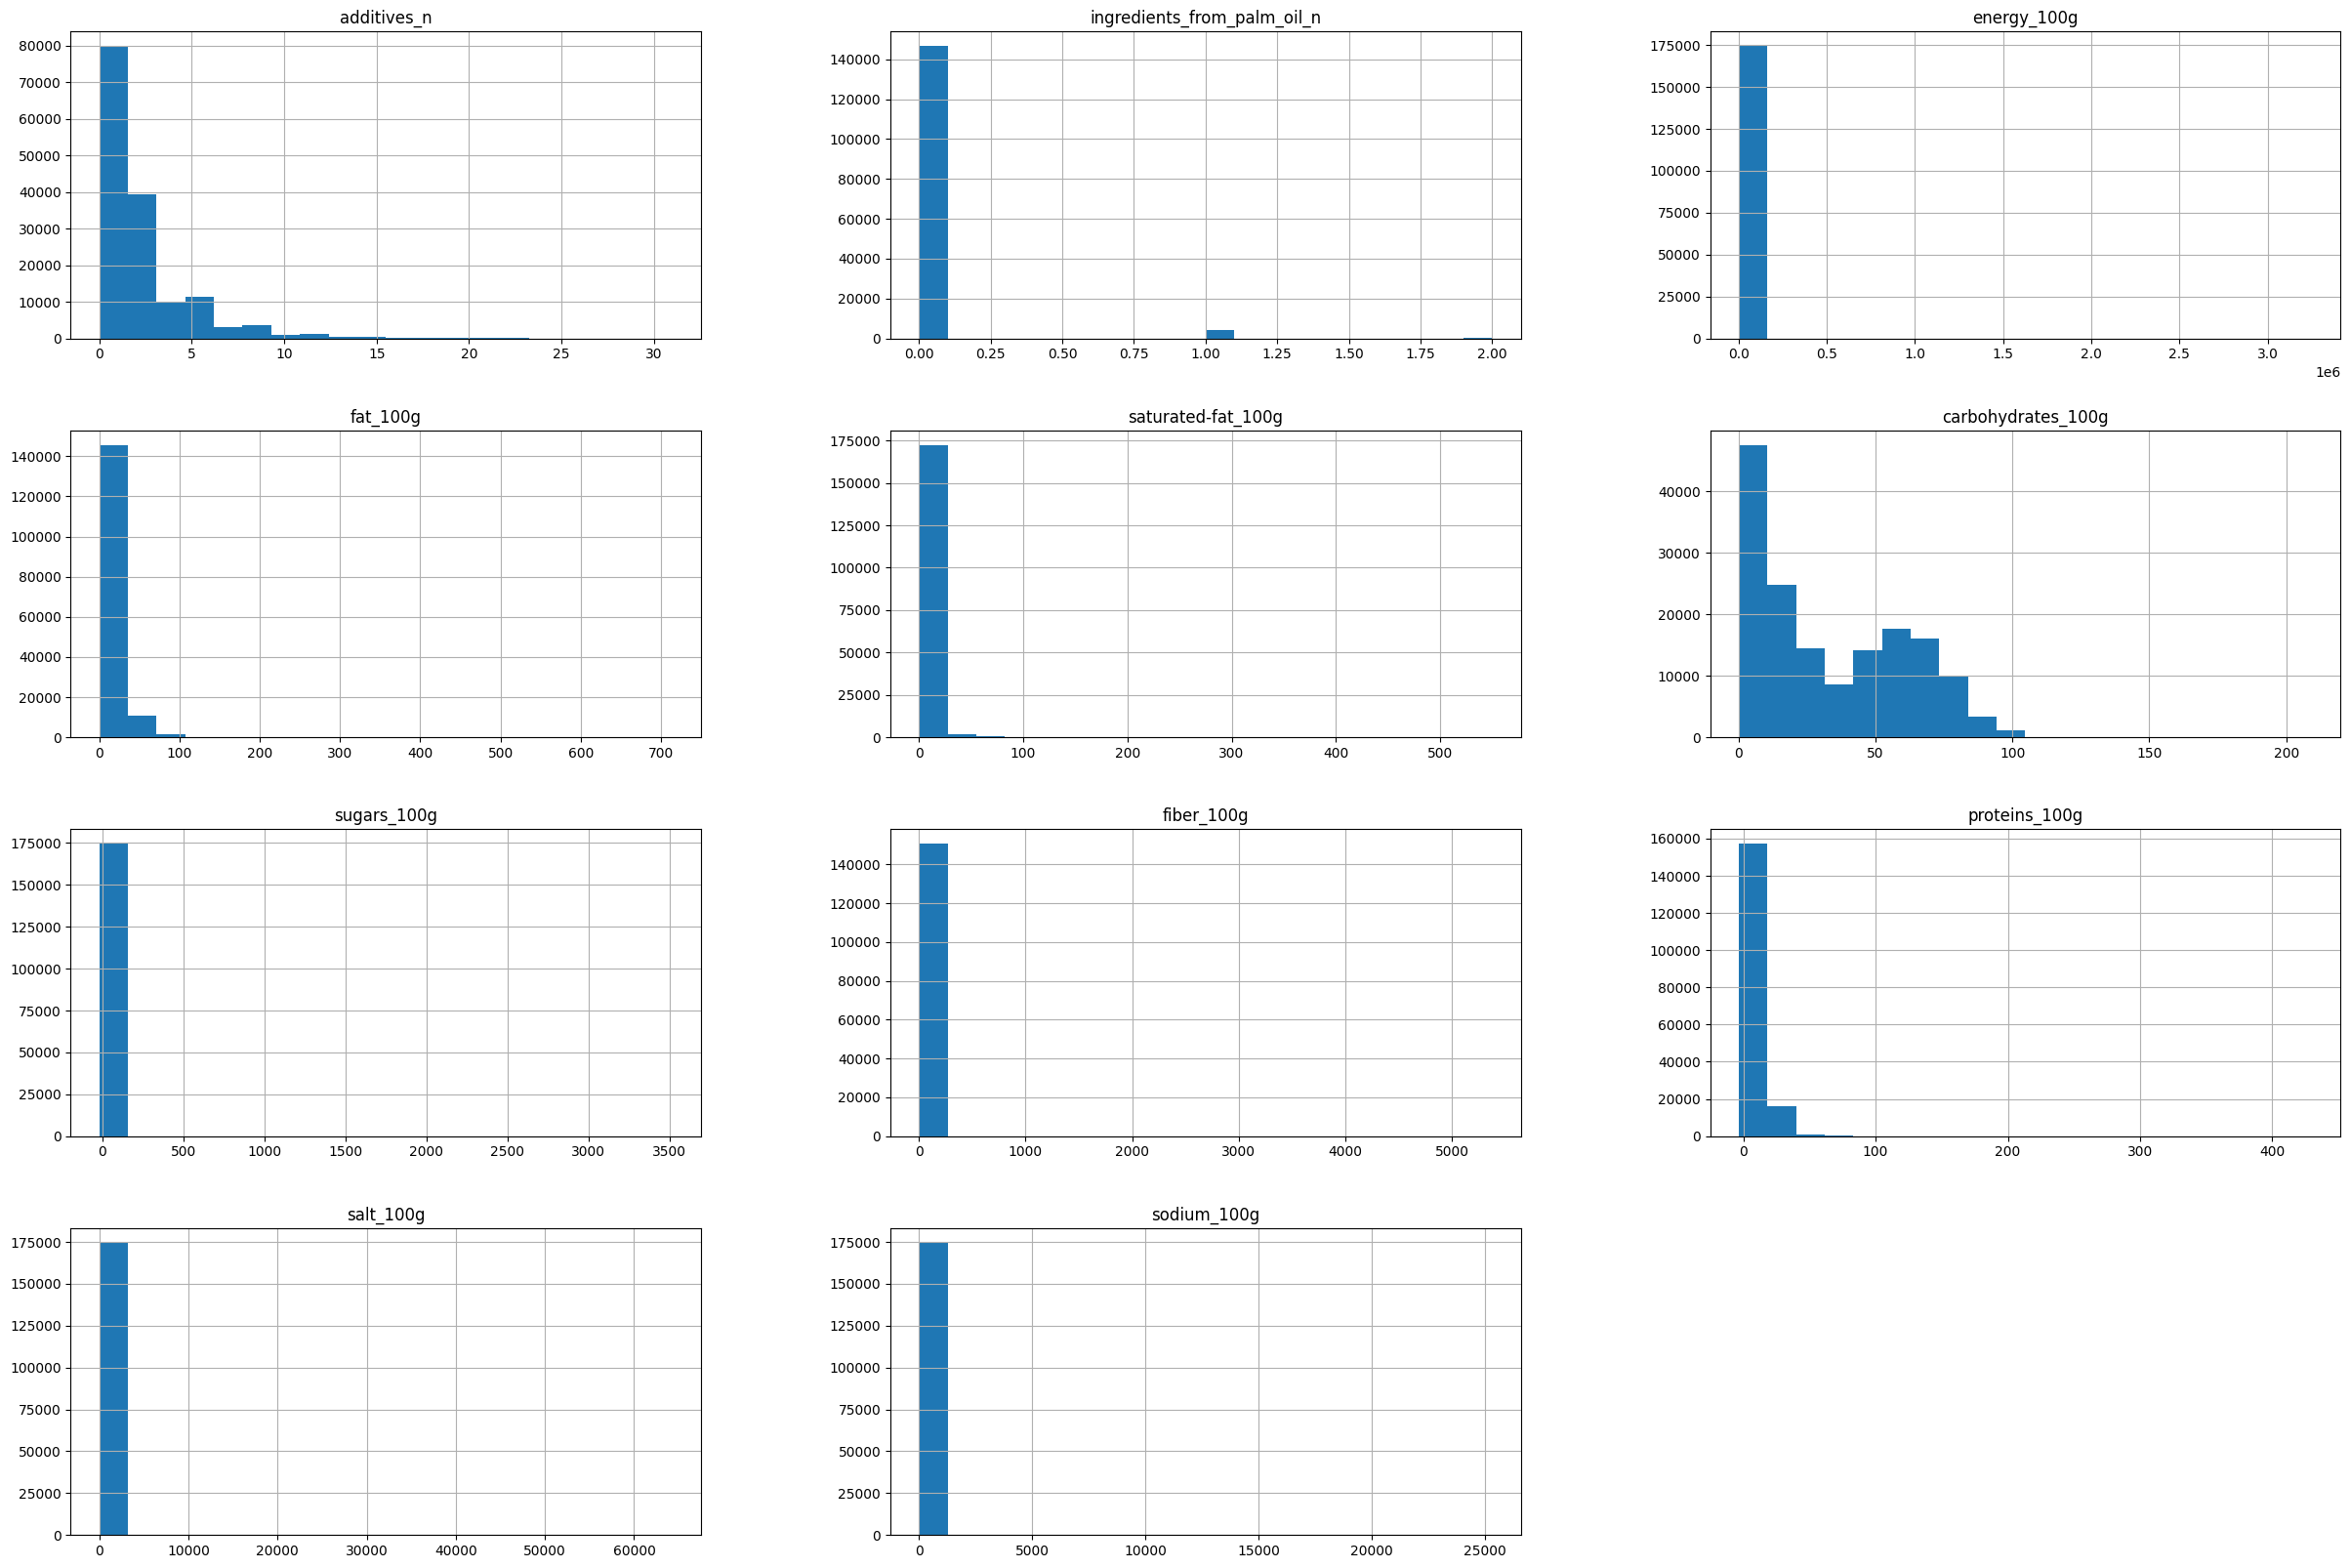

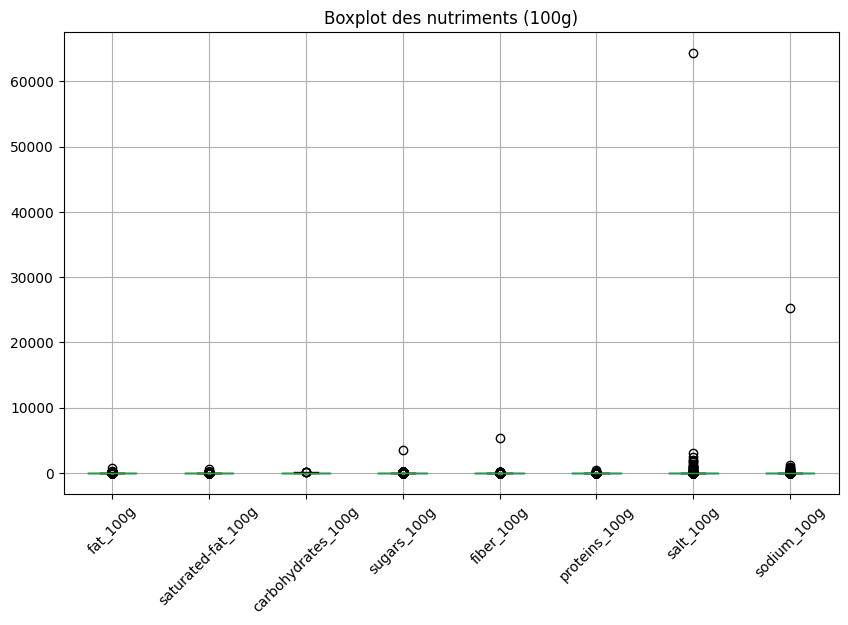

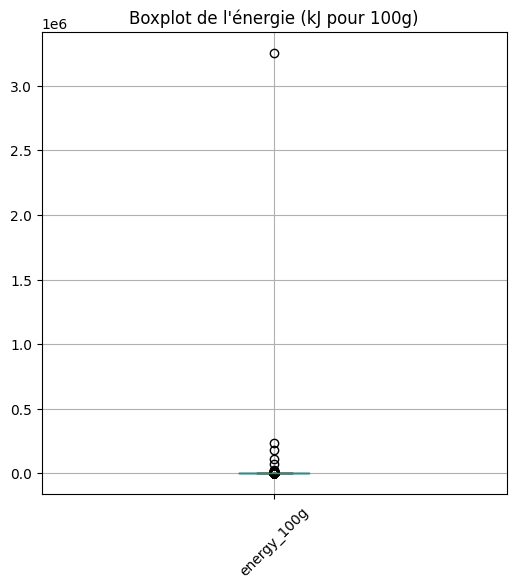

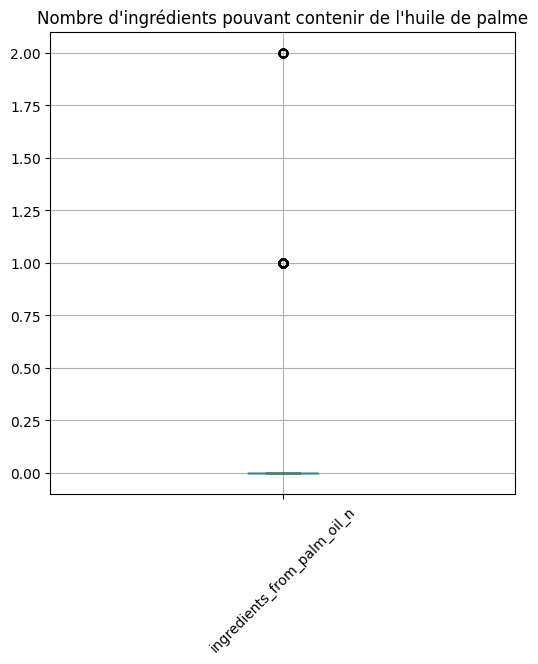

In [17]:
df_cleaned.hist(bins=20, figsize=(30, 20))
plt.show()

nutriment_features = [col for col in df_cleaned.columns if col.endswith('_100g') and col != 'energy_100g']

# Figures des nutriments
plt.figure(figsize=(10, 6))
df_cleaned[nutriment_features].boxplot() 
plt.title("Boxplot des nutriments (100g)")
plt.xticks(rotation=45)
plt.show()

# Figure pour l'énergie
plt.figure(figsize=(6, 6))
df_cleaned[['energy_100g']].boxplot()
plt.title("Boxplot de l'énergie (kJ pour 100g)")
plt.xticks(rotation=45)
plt.show()

# Figure pour l'huile de palme
plt.figure(figsize=(6, 6))
df_cleaned[['ingredients_from_palm_oil_n']].boxplot()
plt.title("Nombre d'ingrédients pouvant contenir de l'huile de palme")
plt.xticks(rotation=45)
plt.show()

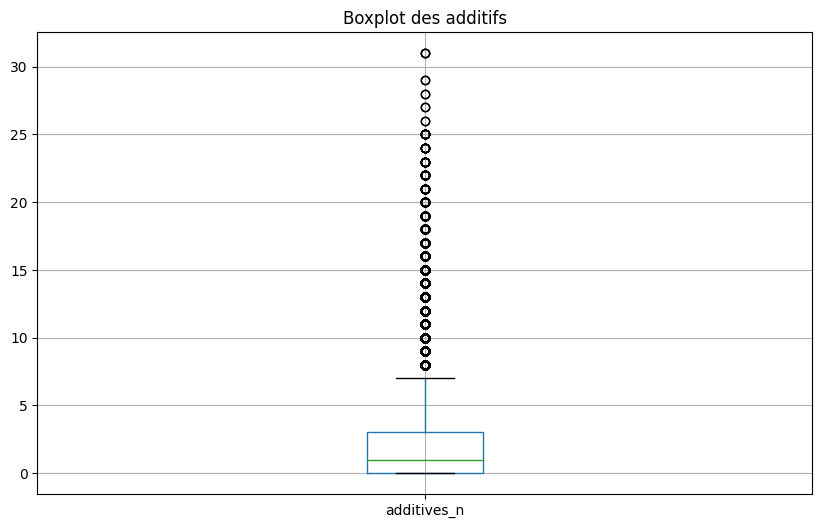

In [18]:
plt.figure(figsize=(10, 6))
df_cleaned[['additives_n']].boxplot() 
plt.title("Boxplot des additifs")
plt.show()

On supprime dans un premier temps les lignes ayant des valeurs aberrerantes d'un pdv métier

In [22]:
df_cleaned = clean_outliers(df_cleaned)

,additives_n,ingredients_from_palm_oil_n,nutrition_grade_fr,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,pnns_groups_1,pnns_groups_2
1,0.0,0.0,d,2243.0,28.57,28.57,64.29,14.29,3.6,3.57,0.00000,0.000000,NaN,NaN
2,0.0,0.0,b,1941.0,17.86,0.00,60.71,17.86,7.1,17.86,0.63500,0.250000,NaN,NaN
3,0.0,0.0,d,2540.0,57.14,5.36,17.86,3.57,7.1,17.86,1.22428,0.482000,NaN,NaN
7,2.0,0.0,c,1833.0,18.75,4.69,57.81,15.62,9.4,14.06,0.13970,0.055000,NaN,NaN
12,1.0,0.0,d,2230.0,36.67,5.00,36.67,3.33,6.7,16.67,1.60782,0.633000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320740,NaN,NaN,d,1084.0,NaN,12.00,NaN,10.50,0.0,8.70,0.29000,0.114173,NaN,NaN
320741,NaN,NaN,b,4.0,NaN,1.00,NaN,1.00,10.0,10.00,10.00000,3.937008,NaN,NaN
320742,0.0,0.0,a,1477.0,0.00,0.00,87.06,2.35,4.7,1.18,0.03048,0.012000,NaN,NaN
320751,NaN,NaN,a,1643.0,2.80,0.60,74.80,2.60,5.9,13.00,0.68000,0.267717,Cereals and potatoes,Bread


pnns_groups_1
Sugary snacks              1559
unknown                     604
Cereals and potatoes        394
Composite foods             250
Salty snacks                154
Fat and sauces              118
Milk and dairy products     105
sugary-snacks                73
Fish Meat Eggs               23
Fruits and vegetables        10
Beverages                     9
fruits-and-vegetables         2
Name: count, dtype: int64


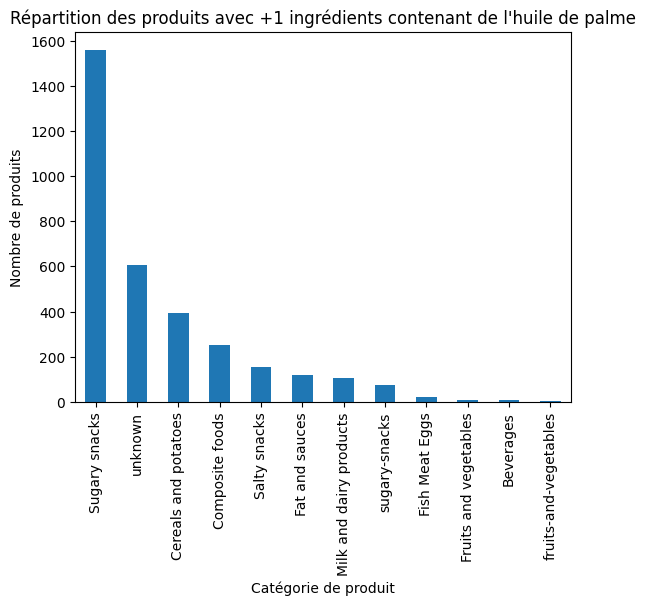

In [23]:
palm_oil_5_ingredients = df_cleaned[df_cleaned['ingredients_from_palm_oil_n'] >= 1]

print(palm_oil_5_ingredients['pnns_groups_1'].value_counts())
palm_oil_5_ingredients['pnns_groups_1'].value_counts().plot(kind='bar')
plt.xlabel("Catégorie de produit")
plt.ylabel("Nombre de produits")
plt.xticks(rotation=90)
plt.title("Répartition des produits avec +1 ingrédients contenant de l'huile de palme")
plt.show()

In [24]:
df_cleaned.describe()

,additives_n,ingredients_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g
count,150597.000000,150597.000000,1.744110e+05,157975.000000,174411.000000,157945.000000,174411.000000,150454.000000,174411.000000,174411.000000,174411.000000
mean,2.116018,0.027052,1.194869e+03,13.251224,4.997881,33.105992,15.143134,2.846796,7.610106,1.782759,0.701874
std,2.630784,0.164108,7.856719e+03,15.363121,7.546890,27.408764,21.062909,14.572812,7.866032,154.676524,60.896269
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-17.860000,0.000000,-3.570000,0.000000,0.000000
25%,0.000000,0.000000,4.810000e+02,1.210000,0.000000,7.650000,1.480000,0.000000,2.200000,0.119380,0.047000
50%,1.000000,0.000000,1.146000e+03,7.960000,2.000000,25.000000,5.600000,1.500000,5.710000,0.680720,0.268000
75%,3.000000,0.000000,1.724000e+03,21.430000,7.140000,57.140000,23.610000,3.600000,10.500000,1.361440,0.536000
max,31.000000,2.000000,3.251373e+06,714.290000,550.000000,209.380000,3520.000000,5380.000000,430.000000,64312.800000,25320.000000


pnns_groups_1
Fat and sauces             164
unknown                     29
Sugary snacks                8
Fish Meat Eggs               4
Beverages                    3
Milk and dairy products      3
Salty snacks                 2
Cereals and potatoes         2
Fruits and vegetables        1
sugary-snacks                1
Name: count, dtype: int64


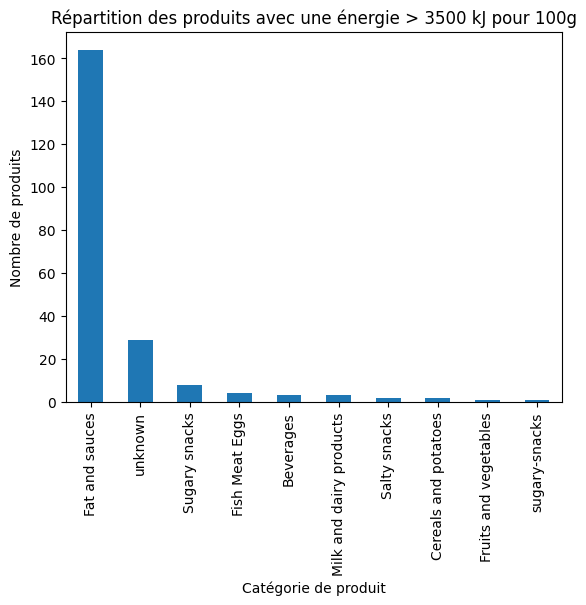

In [25]:
energy_threshold = 3500

high_energy_products = df_cleaned[df_cleaned['energy_100g'] > energy_threshold]

print(high_energy_products['pnns_groups_1'].value_counts())

high_energy_products['pnns_groups_1'].value_counts().plot(kind='bar')
plt.xlabel("Catégorie de produit")
plt.ylabel("Nombre de produits")
plt.title("Répartition des produits avec une énergie > 3500 kJ pour 100g")
plt.show()

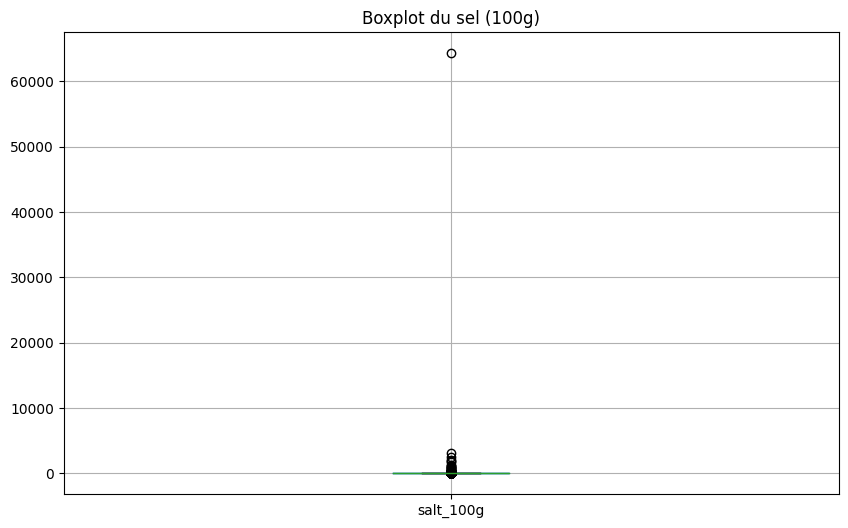

(array([1]), [Text(1, 0, 'sodium_100g')])

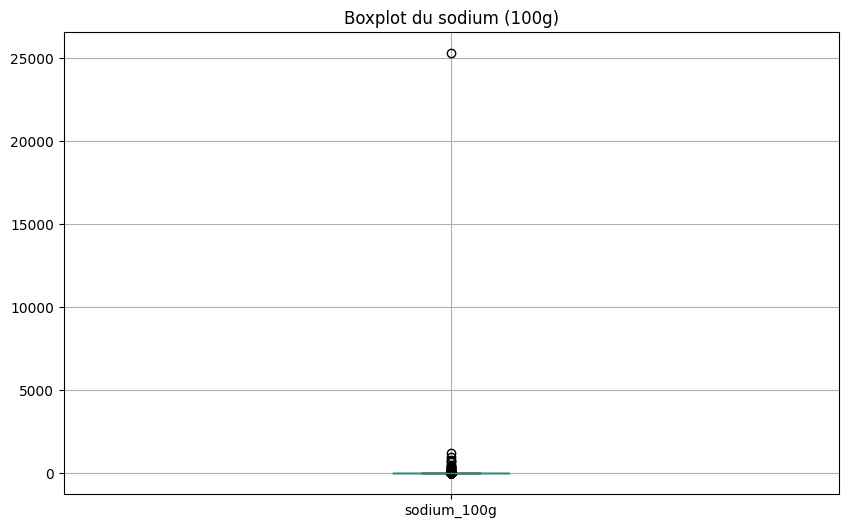

In [26]:
plt.figure(figsize=(10, 6))
df_cleaned[['salt_100g']].boxplot() 
plt.title("Boxplot du sel (100g)")
plt.xticks(rotation=0)
plt.show()

plt.figure(figsize=(10, 6))
df_cleaned[['sodium_100g']].boxplot() 
plt.title("Boxplot du sodium (100g)")
plt.xticks(rotation=0)

pnns_groups_1
Fat and sauces             235
unknown                    205
Fish Meat Eggs             183
Cereals and potatoes        32
Composite foods             11
Fruits and vegetables       11
Beverages                    6
Salty snacks                 6
Milk and dairy products      4
Sugary snacks                3
Name: count, dtype: int64


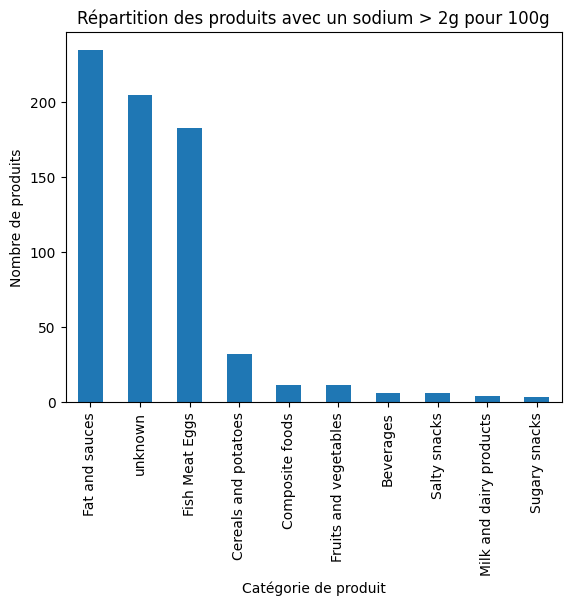

In [23]:
sodium_threshold = 2

high_sodium_products = df_cleaned[df_cleaned['sodium_100g'] > sodium_threshold]

print(high_sodium_products['pnns_groups_1'].value_counts())

high_sodium_products['pnns_groups_1'].value_counts().plot(kind='bar')
plt.xlabel("Catégorie de produit")
plt.ylabel("Nombre de produits")
plt.title("Répartition des produits avec un sodium > 2g pour 100g")
plt.show()

pnns_groups_1
Fish Meat Eggs             545
unknown                    524
Fat and sauces             347
Cereals and potatoes        54
Fruits and vegetables       32
Salty snacks                28
Composite foods             21
Beverages                   14
Sugary snacks               13
Milk and dairy products     11
Name: count, dtype: int64


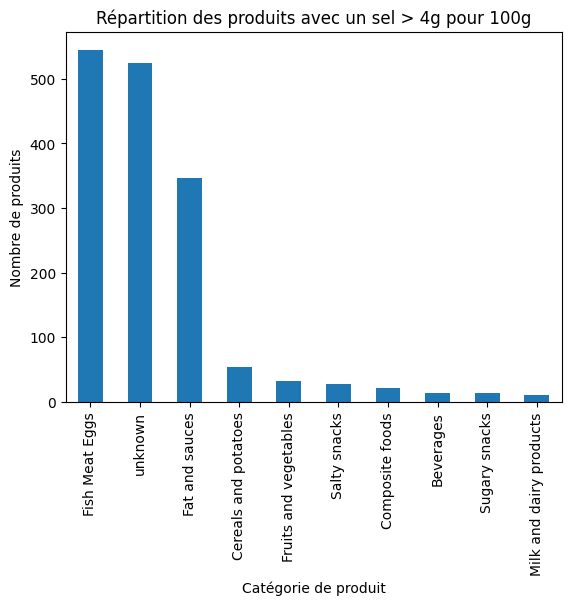

In [27]:
salt_threshold = 4

high_salt_products = df_cleaned[df_cleaned['salt_100g'] > salt_threshold]

print(high_salt_products['pnns_groups_1'].value_counts())

high_salt_products['pnns_groups_1'].value_counts().plot(kind='bar')
plt.xlabel("Catégorie de produit")
plt.ylabel("Nombre de produits")
plt.title("Répartition des produits avec un sel > 4g pour 100g")
plt.show()

In [28]:
outliers_by_category = {}

for category, group in df_cleaned.groupby('pnns_groups_1'):
    outliers_by_category[category] = {}
    for column in [ 'energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g']:
        if column in group.columns and group[column].notnull().any():
            outliers = detect_outliers_iqr(group, column)
            outliers_by_category[category][column] = outliers

expert_thresholds = {
    'energy_100g': {'min': 0, 'max': 4000},
    'fat_100g': {'min': 0, 'max': 100},
    'saturated-fat_100g': {'min': 0, 'max': 90},
    'carbohydrates_100g': {'min': 0, 'max': 100},
    'sugars_100g': {'min': 0, 'max': 100},
    'fiber_100g': {'min': 0, 'max': 45},
    'proteins_100g': {'min': 0, 'max': 90},
    'salt_100g': {'min': 0, 'max': 10},
    'sodium_100g': {'min': 0, 'max': 6}
}

comparison_results = {}

for category, columns in outliers_by_category.items():
    comparison_results[category] = {}
    for column, outliers in columns.items():
        if column in expert_thresholds:
            expert_min = expert_thresholds[column]['min']
            expert_max = expert_thresholds[column]['max']
            outliers_expert = group[(group[column] < expert_min) | (group[column] > expert_max)]

            comparison_results[category][column] = {
                'IQR_outliers': len(outliers),
                'Expert_outliers': len(outliers_expert)
            }

display(comparison_results)

{'Beverages': {'energy_100g': {'IQR_outliers': 557, 'Expert_outliers': 10},
  'fat_100g': {'IQR_outliers': 592, 'Expert_outliers': 0},
  'saturated-fat_100g': {'IQR_outliers': 782, 'Expert_outliers': 2},
  'carbohydrates_100g': {'IQR_outliers': 365, 'Expert_outliers': 5},
  'sugars_100g': {'IQR_outliers': 379, 'Expert_outliers': 5},
  'fiber_100g': {'IQR_outliers': 193, 'Expert_outliers': 14},
  'proteins_100g': {'IQR_outliers': 549, 'Expert_outliers': 4},
  'salt_100g': {'IQR_outliers': 587, 'Expert_outliers': 229},
  'sodium_100g': {'IQR_outliers': 589, 'Expert_outliers': 178}},
 'Cereals and potatoes': {'energy_100g': {'IQR_outliers': 295,
   'Expert_outliers': 10},
  'fat_100g': {'IQR_outliers': 520, 'Expert_outliers': 0},
  'saturated-fat_100g': {'IQR_outliers': 685, 'Expert_outliers': 2},
  'carbohydrates_100g': {'IQR_outliers': 0, 'Expert_outliers': 5},
  'sugars_100g': {'IQR_outliers': 1005, 'Expert_outliers': 5},
  'fiber_100g': {'IQR_outliers': 262, 'Expert_outliers': 14},
  

In [29]:
print(df_cleaned.isnull().sum())

additives_n                     23897
ingredients_from_palm_oil_n     23897
nutrition_grade_fr                  0
energy_100g                        83
fat_100g                        16519
saturated-fat_100g                 83
carbohydrates_100g              16549
sugars_100g                        83
fiber_100g                      24040
proteins_100g                      83
salt_100g                          83
sodium_100g                        83
pnns_groups_1                  117571
pnns_groups_2                  117470
dtype: int64


<Axes: >

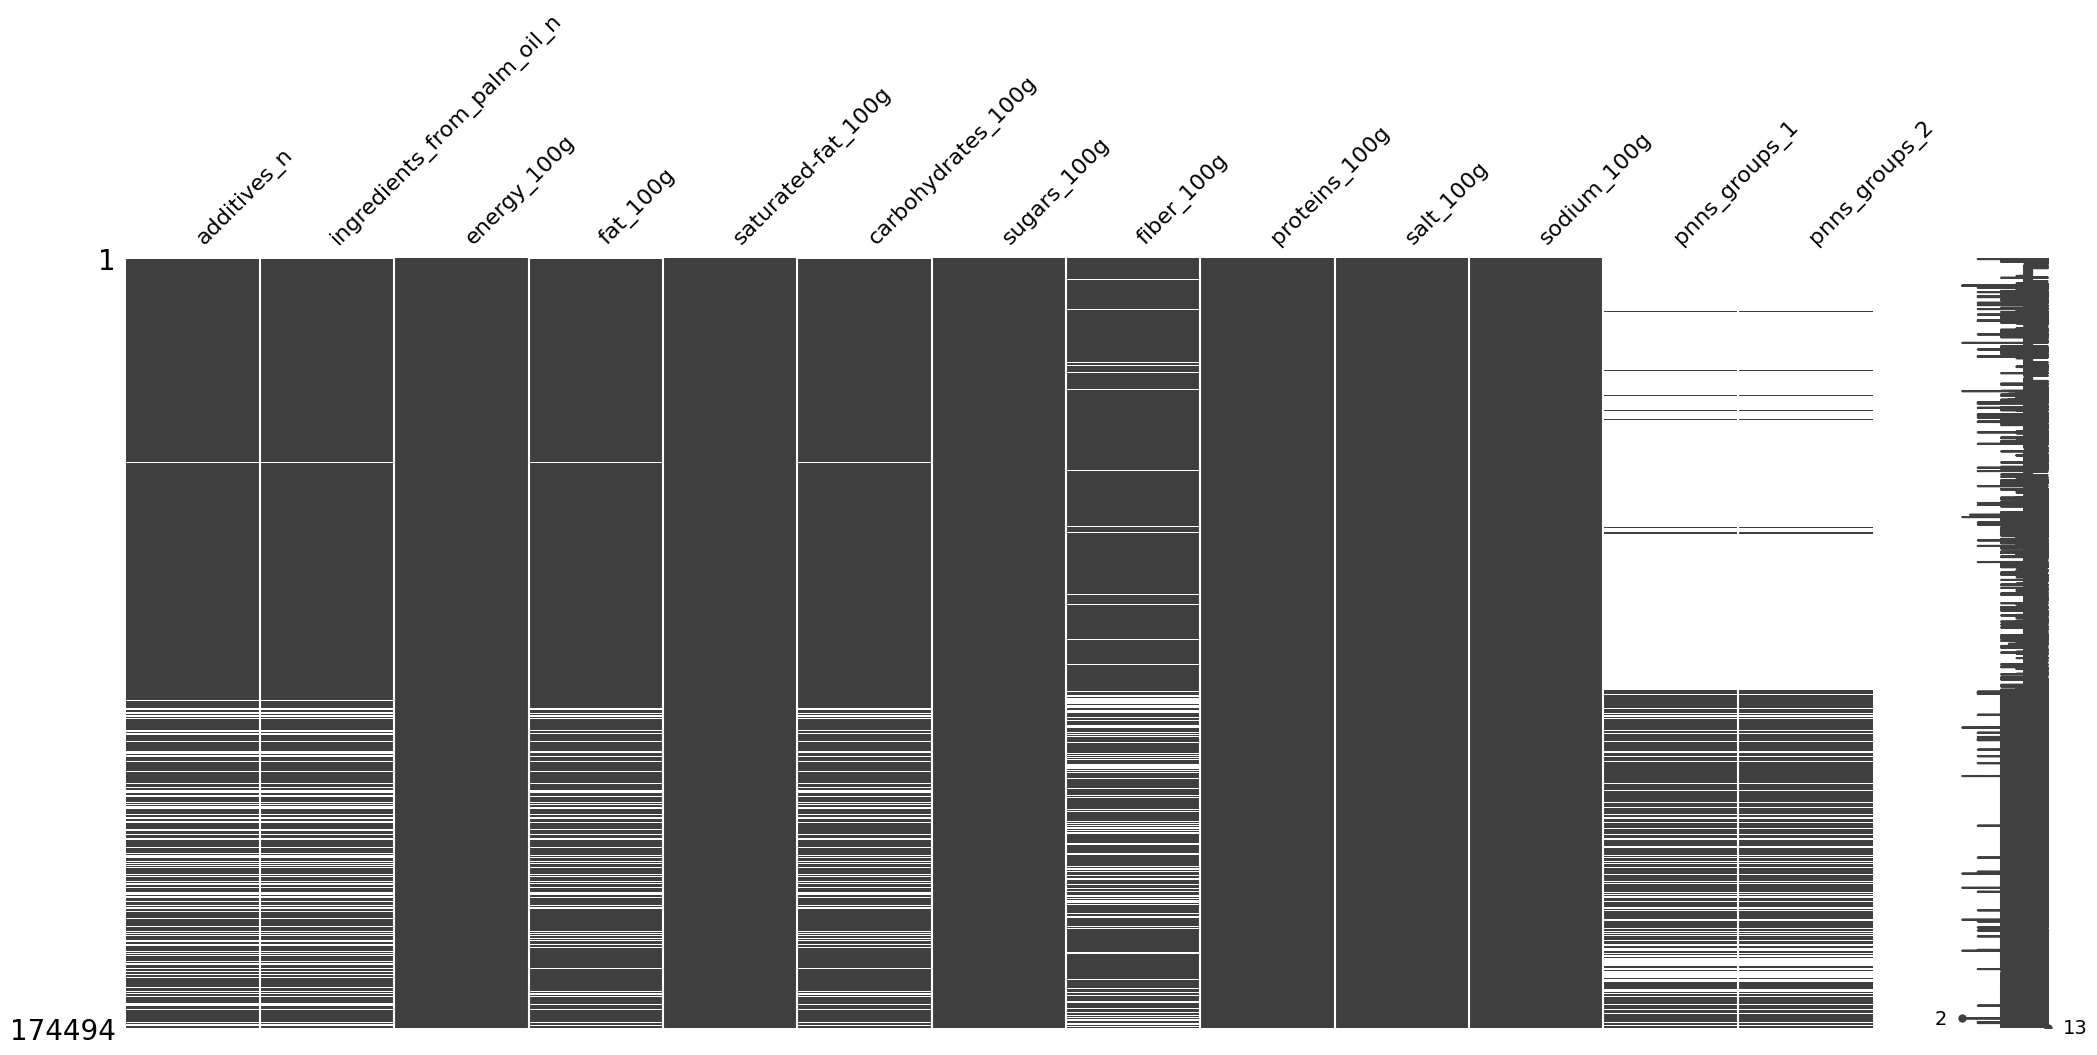

In [30]:
msno.matrix(df_cleaned[df_cleaned.columns[df_cleaned.isnull().any()]])

In [40]:
unique_values = df_cleaned['pnns_groups_1'].unique()

print("Valeurs uniques dans la colonne 'pnns_groups_1' :")
print(unique_values)

Valeurs uniques dans la colonne 'pnns_groups_1' :
[nan 'unknown' 'Fruits and vegetables' 'Sugary snacks' 'Composite foods'
 'Beverages' 'Fish Meat Eggs' 'Fat and sauces' 'Cereals and potatoes'
 'Milk and dairy products' 'Salty snacks']


In [38]:
df_cleaned = df_cleaned.replace('fruits-and-vegetables', 'Fruits and vegetables')
df_cleaned = df_cleaned.replace('sugary-snacks', 'Sugary snacks')
df_cleaned = df_cleaned.replace('salty-snacks', 'Salty snacks')
df_cleaned = df_cleaned.replace('cereals-and-potatoes', 'Cereals and potatoes')

In [36]:
unique_values = df_cleaned['pnns_groups_2'].unique()

print("Valeurs uniques dans la colonne 'pnns_groups_2' :")
print(unique_values)

Valeurs uniques dans la colonne 'pnns_groups_2' :
[nan 'unknown' 'Vegetables' 'Biscuits and cakes' 'Pizza pies and quiche'
 'Sweets' 'Sweetened beverages' 'One-dish meals' 'Soups' 'Meat'
 'Dressings and sauces' 'Cereals' 'Fruits' 'Milk and yogurt' 'Fats'
 'Non-sugared beverages' 'Cheese' 'Chocolate products' 'Sandwich' 'Bread'
 'Nuts' 'Legumes' 'Breakfast cereals' 'Appetizers' 'Fruit juices' 'Eggs'
 'Fish and seafood' 'Dried fruits' 'Ice cream' 'Processed meat'
 'vegetables' 'pastries' 'Dairy desserts' 'Alcoholic beverages' 'Potatoes'
 'Artificially sweetened beverages' 'Fruit nectars' 'fruits'
 'Salty and fatty products' 'Tripe dishes' 'cereals' 'legumes' 'nuts']


In [41]:
feature = 'fiber_100g'  # Exemple : remplacez par la colonne de votre choix

# Calculer le pourcentage de valeurs manquantes par catégorie
missing_percentage = df_cleaned.groupby('pnns_groups_1')[feature].apply(lambda x: x.isnull().mean())

# Filtrer les catégories avec plus de 80% de valeurs manquantes
categories_with_high_missing = missing_percentage[missing_percentage > 0.8]

# Afficher les catégories
if not categories_with_high_missing.empty:
    print("Catégories avec plus de 80% de valeurs manquantes dans la feature :")
    print(categories_with_high_missing)
else:
    print(f"Aucune catégorie n'a plus de 80% de valeurs manquantes pour la feature '{feature}'.")

Aucune catégorie n'a plus de 80% de valeurs manquantes pour la feature 'fiber_100g'.


In [42]:
fiber_categories = ['Beverages', 'Fish Meat Eggs', 'Fat and sauces', 'Milk and dairy products']
fiber_subcategories = [
    'Meat', 'Fish and seafood', 'Eggs', 'Cheese', 'Processed meat', 
    'Fats', 'Dairy desserts', 'Milk and yogurt', 'Sweetened beverages', 
    'Non-sugared beverages', 'Alcoholic beverages', 'Fruit juices', 
    'Artificially sweetened beverages', 'Fruit nectars', 'Dressings and sauces', 
    'Chocolate products', 'Ice cream', 'Sweets', 'Salty and fatty products', 
    'Tripe dishes'
]

carbohydrate_categories = ['Fish Meat Eggs', 'Fat and sauces', 'Milk and dairy products', 'Beverages']
carbohydrate_subcategories = [
    'Meat', 'Fish and seafood', 'Eggs', 'Cheese', 'Processed meat', 
    'Fats', 'Milk and yogurt', 'Non-sugared beverages', 'Alcoholic beverages', 
    'Artificially sweetened beverages', 'Dressings and sauces', 'Tripe dishes'
]

sugar_categories = ['Fish Meat Eggs', 'Fat and sauces', 'Milk and dairy products', 'Beverages']
sugar_subcategories = [
    'Meat', 'Fish and seafood', 'Eggs', 'Cheese', 'Processed meat', 
    'Fats', 'Non-sugared beverages', 'Alcoholic beverages', 
    'Artificially sweetened beverages', 'Dressings and sauces', 'Tripe dishes'
]

saturated_fat_categories = ['Fruits and vegetables', 'Beverages']
saturated_fat_subcategories = [
    'Vegetables', 'Fruits', 'Non-sugared beverages', 'Alcoholic beverages', 
    'Artificially sweetened beverages', 'Fruit juices', 'Fruit nectars'
]

fat_categories = ['Beverages', 'Fruits and vegetables', 'Cereals and potatoes']
fat_subcategories = [
    'Vegetables', 'Fruits', 'Cereals', 'Potatoes', 'Non-sugared beverages', 
    'Sweetened beverages', 'Alcoholic beverages', 'Artificially sweetened beverages', 
    'Fruit juices', 'Fruit nectars'
]

protein_categories = ['Fat and sauces', 'Sugary snacks', 'Beverages']
protein_subcategories = [
    'Fats', 'Dressings and sauces', 'Sweets', 'Sweetened beverages', 
    'Non-sugared beverages', 'Artificially sweetened beverages', 
    'Alcoholic beverages', 'Fruit juices', 'Fruit nectars', 'Ice cream'
]

sodium_categories = ['Fruits and vegetables', 'Beverages']
salt_categories = sodium_categories

sodium_subcategories = [
    'Vegetables', 'Fruits', 'Non-sugared beverages', 'Sweetened beverages', 
    'Artificially sweetened beverages', 'Alcoholic beverages', 'Fruit juices', 
    'Fruit nectars'
]
salt_subcategories = sodium_subcategories


In [44]:
df_cleaned.loc[df_cleaned['pnns_groups_1'].isin(fiber_categories), 'fiber_100g'] = \
    df_cleaned.loc[df_cleaned['pnns_groups_1'].isin(fiber_categories), 'fiber_100g'].fillna(0)

df_cleaned.loc[df_cleaned['pnns_groups_2'].isin(fiber_subcategories), 'fiber_100g'] = \
    df_cleaned.loc[df_cleaned['pnns_groups_2'].isin(fiber_subcategories), 'fiber_100g'].fillna(0)

df_cleaned.loc[df_cleaned['pnns_groups_1'].isin(carbohydrate_categories), 'carbohydrates_100g'] = \
    df_cleaned.loc[df_cleaned['pnns_groups_1'].isin(carbohydrate_categories), 'carbohydrates_100g'].fillna(0)

df_cleaned.loc[df_cleaned['pnns_groups_2'].isin(carbohydrate_subcategories), 'carbohydrates_100g'] = \
    df_cleaned.loc[df_cleaned['pnns_groups_2'].isin(carbohydrate_subcategories), 'carbohydrates_100g'].fillna(0)

df_cleaned.loc[df_cleaned['pnns_groups_1'].isin(sugar_categories), 'sugars_100g'] = \
    df_cleaned.loc[df_cleaned['pnns_groups_1'].isin(sugar_categories), 'sugars_100g'].fillna(0)

df_cleaned.loc[df_cleaned['pnns_groups_2'].isin(sugar_subcategories), 'sugars_100g'] = \
    df_cleaned.loc[df_cleaned['pnns_groups_2'].isin(sugar_subcategories), 'sugars_100g'].fillna(0)

df_cleaned.loc[df_cleaned['pnns_groups_1'].isin(saturated_fat_categories), 'saturated-fat_100g'] = \
    df_cleaned.loc[df_cleaned['pnns_groups_1'].isin(saturated_fat_categories), 'saturated-fat_100g'].fillna(0)

df_cleaned.loc[df_cleaned['pnns_groups_2'].isin(saturated_fat_subcategories), 'saturated-fat_100g'] = \
    df_cleaned.loc[df_cleaned['pnns_groups_2'].isin(saturated_fat_subcategories), 'saturated-fat_100g'].fillna(0)

df_cleaned.loc[df_cleaned['pnns_groups_1'].isin(fat_categories), 'fat_100g'] = \
    df_cleaned.loc[df_cleaned['pnns_groups_1'].isin(fat_categories), 'fat_100g'].fillna(0)

df_cleaned.loc[df_cleaned['pnns_groups_2'].isin(fat_subcategories), 'fat_100g'] = \
    df_cleaned.loc[df_cleaned['pnns_groups_2'].isin(fat_subcategories), 'fat_100g'].fillna(0)

df_cleaned.loc[df_cleaned['pnns_groups_1'].isin(protein_categories), 'proteins_100g'] = \
    df_cleaned.loc[df_cleaned['pnns_groups_1'].isin(protein_categories), 'proteins_100g'].fillna(0)

df_cleaned.loc[df_cleaned['pnns_groups_2'].isin(protein_subcategories), 'proteins_100g'] = \
    df_cleaned.loc[df_cleaned['pnns_groups_2'].isin(protein_subcategories), 'proteins_100g'].fillna(0)

df_cleaned.loc[df_cleaned['pnns_groups_1'].isin(sodium_categories), 'sodium_100g'] = \
    df_cleaned.loc[df_cleaned['pnns_groups_1'].isin(sodium_categories), 'sodium_100g'].fillna(0)

df_cleaned.loc[df_cleaned['pnns_groups_2'].isin(sodium_subcategories), 'sodium_100g'] = \
    df_cleaned.loc[df_cleaned['pnns_groups_2'].isin(sodium_subcategories), 'sodium_100g'].fillna(0)

df_cleaned.loc[df_cleaned['pnns_groups_1'].isin(salt_categories), 'salt_100g'] = \
    df_cleaned.loc[df_cleaned['pnns_groups_1'].isin(salt_categories), 'salt_100g'].fillna(0)

df_cleaned.loc[df_cleaned['pnns_groups_2'].isin(salt_subcategories), 'salt_100g'] = \
    df_cleaned.loc[df_cleaned['pnns_groups_2'].isin(salt_subcategories), 'salt_100g'].fillna(0)

In [50]:
numeric_features = df_cleaned.select_dtypes(include=['number']).columns

for feature in numeric_features:
    df_cleaned[feature] = df_cleaned[feature].where(
        df_cleaned[feature].notnull(),
        df_cleaned.groupby('pnns_groups_1')[feature].transform('median')
    )
    df_cleaned[feature] = df_cleaned[feature].where(
        df_cleaned[feature].notnull(),
        df_cleaned.groupby('pnns_groups_2')[feature].transform('median')
    )

print(df_cleaned.isnull().sum())

additives_n                     15942
ingredients_from_palm_oil_n     15942
nutrition_grade_fr                  0
energy_100g                         0
fat_100g                        13166
saturated-fat_100g                  0
carbohydrates_100g              13140
sugars_100g                         0
fiber_100g                       4263
proteins_100g                       0
salt_100g                           0
sodium_100g                         0
pnns_groups_1                  117571
pnns_groups_2                  117470
dtype: int64


<Axes: >

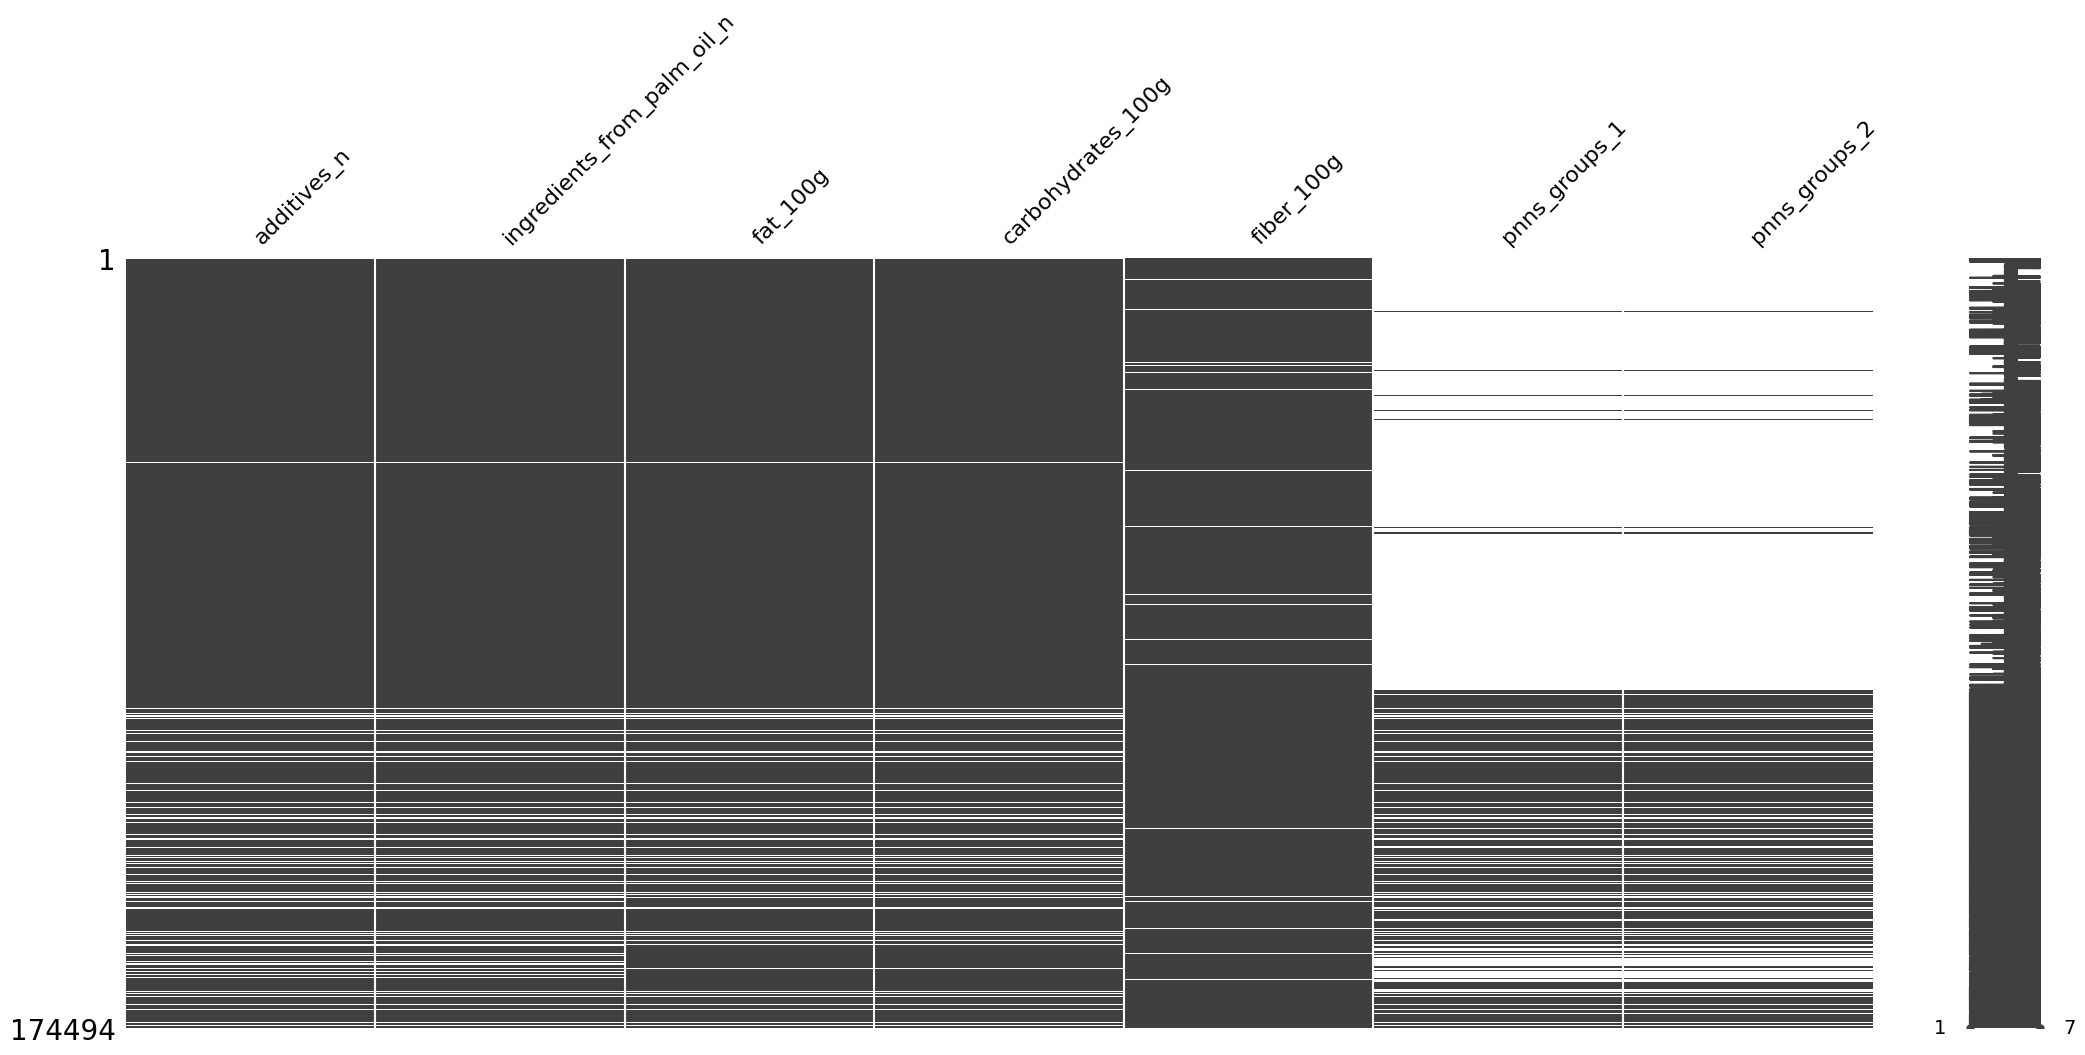

In [51]:
msno.matrix(df_cleaned[df_cleaned.columns[df_cleaned.isnull().any()]])

In [59]:
produits_sans_categorie = df_cleaned[df_cleaned['pnns_groups_1'].isnull() | (df_cleaned['pnns_groups_1'] == '') | (df_cleaned['pnns_groups_1'] == 'unknown')]

print("Produits sans catégorie :")
display(produits_sans_categorie)

Produits sans catégorie :


,additives_n,ingredients_from_palm_oil_n,nutrition_grade_fr,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,pnns_groups_1,pnns_groups_2
1,0.0,0.0,d,2243.0,28.57,28.57,64.29,14.29,3.6,3.57,0.00000,0.000000,NaN,NaN
2,0.0,0.0,b,1941.0,17.86,0.00,60.71,17.86,7.1,17.86,0.63500,0.250000,NaN,NaN
3,0.0,0.0,d,2540.0,57.14,5.36,17.86,3.57,7.1,17.86,1.22428,0.482000,NaN,NaN
7,2.0,0.0,c,1833.0,18.75,4.69,57.81,15.62,9.4,14.06,0.13970,0.055000,NaN,NaN
12,1.0,0.0,d,2230.0,36.67,5.00,36.67,3.33,6.7,16.67,1.60782,0.633000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320698,NaN,NaN,d,1996.0,NaN,10.00,NaN,22.00,6.0,22.00,1.00000,0.393701,NaN,NaN
320740,NaN,NaN,d,1084.0,NaN,12.00,NaN,10.50,0.0,8.70,0.29000,0.114173,NaN,NaN
320741,NaN,NaN,b,4.0,NaN,1.00,NaN,1.00,10.0,10.00,10.00000,3.937008,NaN,NaN
320742,0.0,0.0,a,1477.0,0.00,0.00,87.06,2.35,4.7,1.18,0.03048,0.012000,NaN,NaN


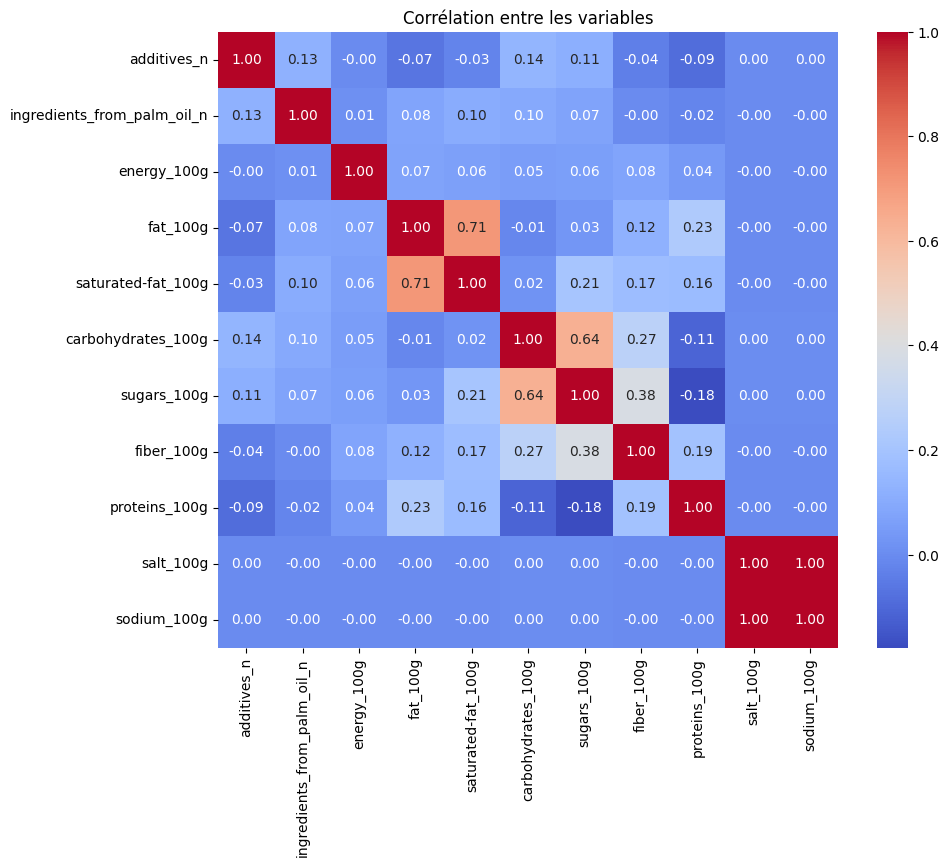

In [55]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_cleaned.select_dtypes(include=['number']).corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Corrélation entre les variables")
plt.show()